<a href="https://colab.research.google.com/github/riverdogcabin/PSDS4900/blob/main/wu_observation_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Only have to do this once for every new instance. The prepackaged sklearn with Collab (0.22.1) does not have PoissonRegressor. 
# Change this cell to code and execute once when you start a brand new runtime.

# !pip uninstall scikit-learn -y

# !pip install -U scikit-learn

In [ ]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
from numpy import arange
import scipy.stats as stats
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, DateFormatter
from matplotlib import cm
import seaborn as sns
from pprint import pprint
import json
from time import sleep

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, Lasso, ElasticNet, BayesianRidge, HuberRegressor, PoissonRegressor, TweedieRegressor
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, GridSearchCV, KFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, FactorAnalysis, NMF
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.neighbors import LocalOutlierFactor
from joblib import dump, load

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
best_model_tracker = {}

In [ ]:
with open('/content/drive/MyDrive/Capstone/PSDS4900/config.json') as configuration:
  my_station = json.load(configuration).get('WU')["stationid"] #'WU' is the parameters for WeatherUnderground

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Capstone/PSDS4900/wu_data/wu_observations.csv')
df['timestamp'] = pd.to_datetime(df['epoch'], unit='s')
df = df.assign(timestamp_rounded=df.timestamp.dt.round('60min')) #rounded to the hour
print('with dupes',df.shape)
before = df.shape[0]
df.drop_duplicates(inplace=True)
print('without dupes',df.shape)
print('difference: ',before-df.shape[0])

with dupes (246032, 34)
without dupes (246032, 34)
difference:  0


### Helper function to grab the N most correlated stations from a big correlation matrix of all statiosn based on one variable (defaul windspeedAvg)

In [ ]:
#deprecated but still useful in some cases so I'm keeping it around
def get_top_n_correlated_old(df,corr_df,num_stations=5,variable='windspeedAvg',my_station='KCOPARKE414'):
  target_stations = corr_df.sort_values(variable+'_corr',ascending=False).stationID.to_list()[:num_stations]
  target_stations.append(my_station)
  df_filtered = df[df.stationID.isin(target_stations)]
  df_reshaped = df_filtered.pivot_table(index='timestamp_rounded',columns='stationID',values=variable)
  before = df_reshaped.shape[0]
  df_reshaped.dropna(inplace=True)
  return df_reshaped, before-df_reshaped.shape[0]

In [ ]:
def get_top_n_correlated(df,corr_df,num_stations=5,variable=['windspeedAvg'],my_station='KCOPARKE414',target_variable='windspeedAvg',return_params=False):
  if(isinstance(variable,str)):
    variable = [variable]
  df_reshaped = pd.DataFrame()
  params = {}
  for var in variable:
    #get num_stations most correlated stations from corr_df for each of the variables in the variable list
    target_stations = corr_df.sort_values(var+'_corr',ascending=False).stationID.to_list()[:num_stations]
    params[var] = target_stations
    # target_stations.append(my_station)
    df_filtered = df[df.stationID.isin(target_stations)]
    if (df_reshaped.shape[0]>0):
      df_reshaped = pd.concat([df_reshaped, df_filtered.pivot_table(index='timestamp_rounded',columns='stationID',values=var)], axis=1)
    else:
      df_reshaped = df_filtered.pivot_table(index='timestamp_rounded',columns='stationID',values=var)
      # before = df_reshaped.shape[0]
  # append my_station windspeedAvg so we have a y target
  df_filtered = df[df.stationID.isin([my_station])]
  df_reshaped = pd.concat([df_reshaped, df_filtered.pivot_table(index='timestamp_rounded',columns='stationID',values=target_variable)], axis=1)
  df_reshaped.dropna(inplace=True)
  if(return_params):
    return df_reshaped, params
  else:
    return df_reshaped

### Clean up the spikes (dupes in each timegroup as outline din the stats notebook)

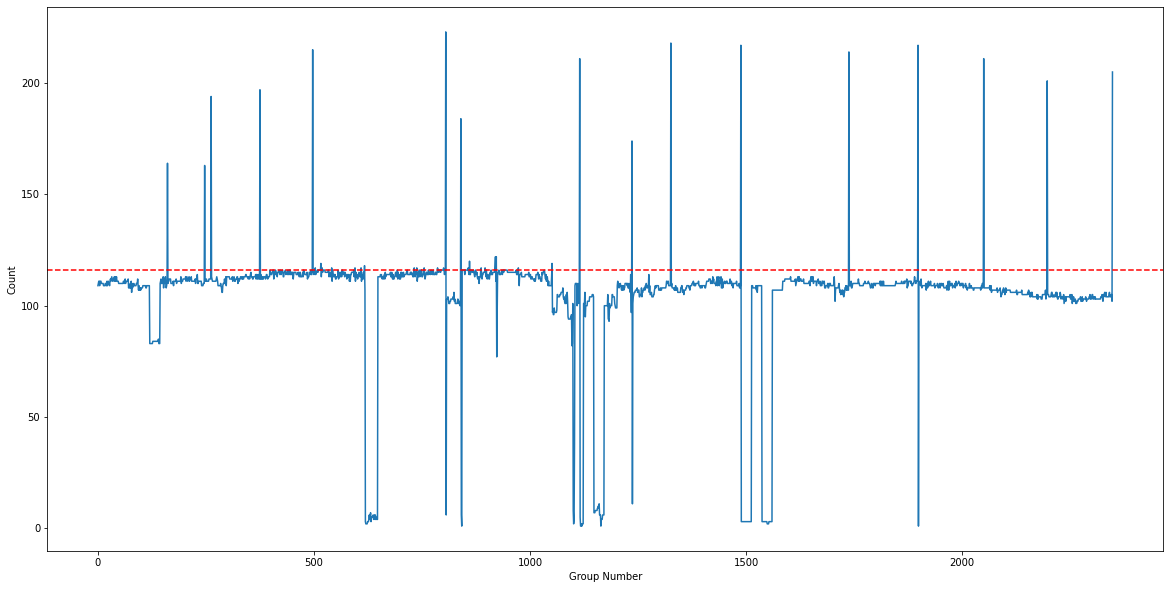

In [ ]:
num_stations = len(df.stationID.unique())
counted_df = df.groupby(['timestamp_rounded']).count().reset_index()
ax = counted_df.windspeedAvg.plot(xlabel='Group Number',ylabel='Count',figsize=(20, 10))
ax.axhline(y=num_stations,color='red',linestyle='--')
hour_grouping_std = counted_df.stationID.std()
# problem_hours = list(counted_df[counted_df.stationID > num_stations+hour_grouping_std].timestamp_rounded) #get all groups that are more than one standard deviation off the station count
# indices_to_drop = df[(df.timestamp_rounded.isin(problem_hours)) & (df.timestamp > df.timestamp_rounded)].index
# df.drop(indices_to_drop,inplace=True)

In [ ]:
timestamp_target_dict = {}
timestamp_groups_to_remove = []
for tsr in set(df.timestamp_rounded):
  # print(tsr)
  target_timestamp = df[(df.stationID == my_station) & (df.timestamp_rounded == tsr)]
  # if(tsr == pd.to_datetime('2021-04-20 16:00:00')):
  #   print(target_timestamp)
  if(not target_timestamp.empty):
    timestamp_target_dict[tsr] = target_timestamp.loc[target_timestamp.timestamp.idxmax()].timestamp
  else:
    timestamp_groups_to_remove.append(tsr) #timestamp group does not contain my station
# timestamp_target_dict

In [ ]:
#get rid of timestamp groups that do not contain my station
df.drop(df[df.timestamp_rounded.isin(timestamp_groups_to_remove)].index,inplace=True)
df.reset_index(drop=True,inplace=True)

In [ ]:
#create target_timestamp and use it to create the offsets so we can only keep observations closest to my_station
df['target_timestamp'] = df.timestamp_rounded.map(timestamp_target_dict)
df['offset'] = df.apply(lambda x: abs((x.timestamp-x.target_timestamp).total_seconds()),axis=1)

In [ ]:
bad_indices = []
problem_hours = list(counted_df[counted_df.stationID > num_stations+hour_grouping_std].timestamp_rounded)

for hour in problem_hours:
  grouped = df[df.timestamp_rounded == hour].groupby('stationID')
  for group in grouped.groups:
    if(np.isnan(grouped.get_group(group).offset.idxmax())):
      print(group, hour)
    bad_indices.append(grouped.get_group(group).offset.idxmax())

bad_indices = bad_indices + list(df[df.timestamp_rounded.isin(timestamp_groups_to_remove)].index)
# drop bad_indices and reset index
df.drop(bad_indices,inplace=True)
df.reset_index(inplace=True, drop=True)
print("Dropped {} rows".format(len(bad_indices)))

Dropped 1536 rows


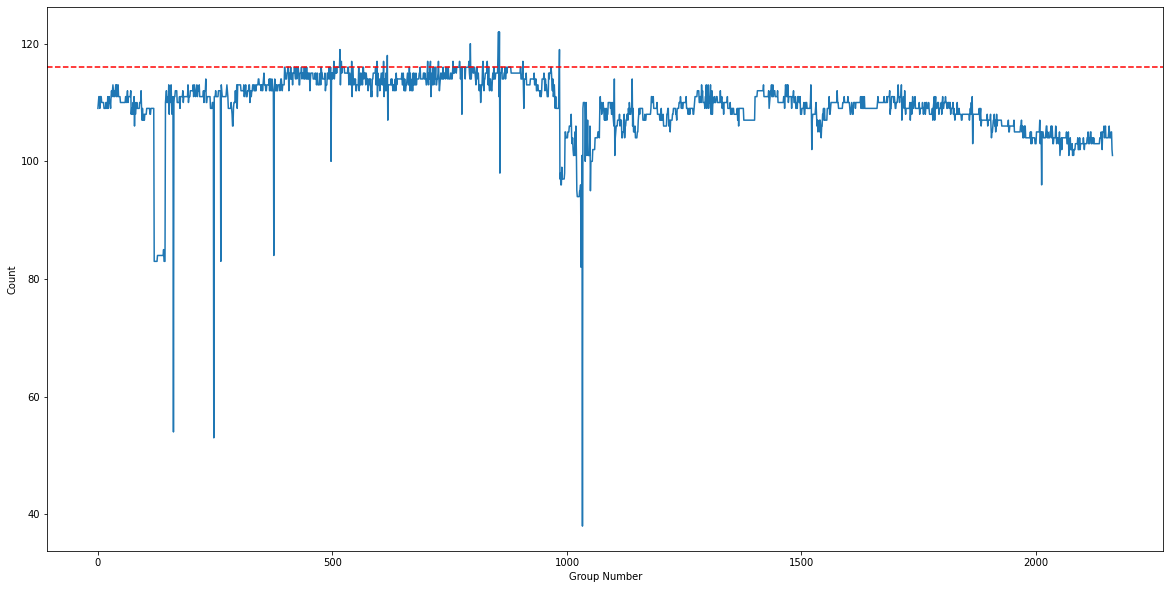

In [ ]:
## uncomment the below to check to make sure the spikes are gone
grouped = df.groupby(['timestamp_rounded'])
ax = grouped.count().reset_index().windspeedAvg.plot(xlabel='Group Number',ylabel='Count',figsize=(20, 10))
ax.axhline(y=num_stations,color='red',linestyle='--')

In [ ]:
#Quick check just within the data from my_station to see which data are most highly correlated with windspeedAvg
df[df.stationID == my_station].corr()[['windspeedAvg']].sort_values(by='windspeedAvg', ascending=False).head(10)


,windspeedAvg
windspeedAvg,1.000000
windgustAvg,0.994614
windspeedHigh,0.835309
windgustHigh,0.819133
windgustLow,0.474977
windspeedLow,0.416865
solarRadiationHigh,0.326725
uvHigh,0.320603
tempHigh,0.193393
windchillHigh,0.193384


In [ ]:
#take all the variables that are correlated > .8 within my_station's readings
columns_to_pull = df[df.stationID == my_station].corr()[['windspeedAvg']].sort_values(by='windspeedAvg', ascending=False)
columns_to_pull = columns_to_pull[columns_to_pull.windspeedAvg > 0.80].index.to_list()
columns_to_pull

['windspeedAvg', 'windgustAvg', 'windspeedHigh', 'windgustHigh']

### Build correlation DataFrame and the dict of maximally correlated stations

In [ ]:
# columns_to_check = [s for s in df.columns if "Avg" in s]
corr_df = pd.DataFrame({'stationID':df.stationID.unique()}) #create the shell of the dataframe to store the correlations
max_correlations = {} #this will hold the maximally correlated stations for each variable
for v in columns_to_pull:
  #create a pivot table for each variable
  temp_df = df.pivot_table(index='timestamp_rounded',columns='stationID',values=v).corr()[[my_station]]
  temp_df.columns.name = None #get rid of the column names and then collapse the indices, reindex and rename the columns
  temp_df = temp_df.stack().reset_index().drop(columns='level_1').rename(columns={0:v+'_corr'})
  #get rid of the results for my_station, obvs 
  temp_df = temp_df[temp_df.stationID != my_station]
  #collect the maximally correlated station for the variable
  max_correlations[v] = temp_df.loc[temp_df[v+'_corr'].abs().idxmax()]
  #add all the corrleations for this variable as a column to the big correlation dataframe
  corr_df = corr_df.merge(temp_df,on='stationID')

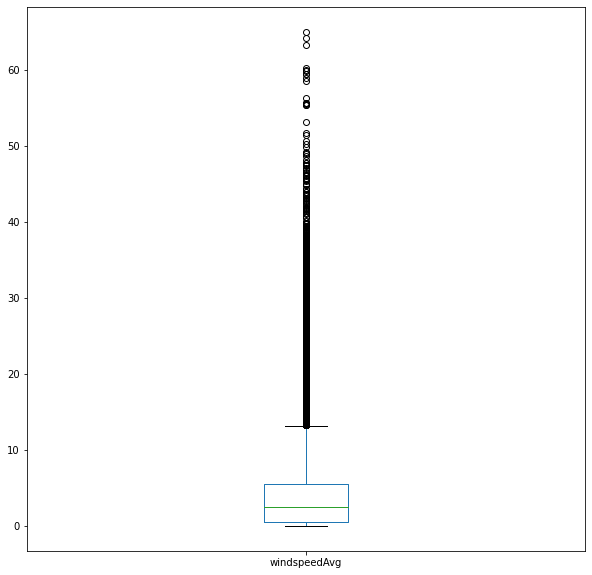

In [ ]:
# taking a look at the distribution of windspeedAvg
df.windspeedAvg.plot(kind='box', figsize=(10,10))

In [ ]:
df.windspeedAvg.describe()

count    237006.000000
mean          3.925435
std           4.712588
min           0.000000
25%           0.500000
50%           2.500000
75%           5.600000
max          65.000000
Name: windspeedAvg, dtype: float64

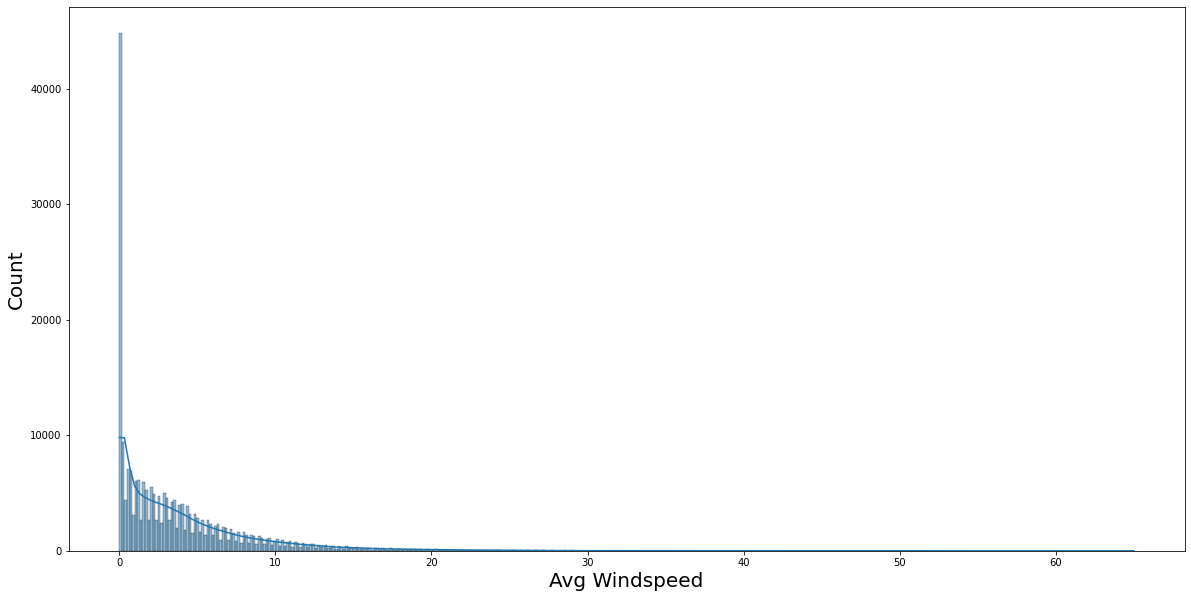

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('Avg Windspeed', fontdict={'fontsize' : 20})
ax.set_ylabel('Count', fontdict={'fontsize' : 20})
# sns.set(font_scale = 2)

sns.histplot(data=df, x="windspeedAvg", kde=True,ax=ax)

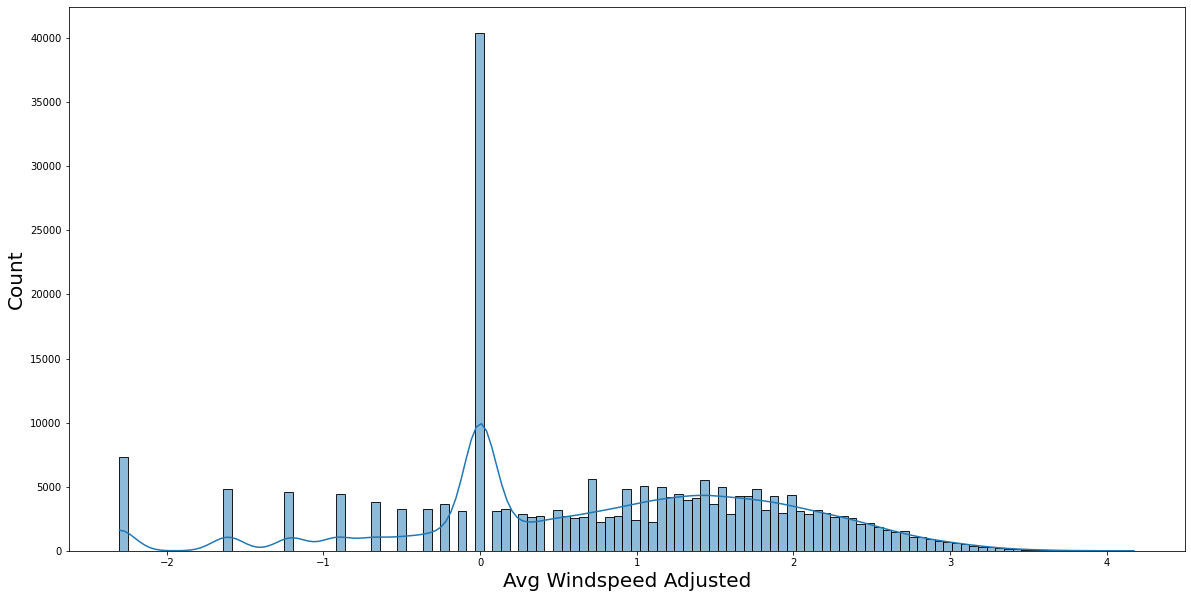

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('Avg Windspeed Adjusted', fontdict={'fontsize' : 20})
ax.set_ylabel('Count', fontdict={'fontsize' : 20})
# sns.set(font_scale = 2)
log_windspeed = [x if x==0.0 else np.log(x) for x in df.windspeedAvg]

sns.histplot(log_windspeed, kde=True,ax=ax)

### Now let's build a simple linear regression model and using a [ great code snippet to set up k-fold cross validation](https://becominghuman.ai/linear-regression-in-python-with-pandas-scikit-learn-72574a2ec1a5) We will step through the 30 most correlated stations' data for each of the variables most closely associated with windspeedAvg. We will used the number of stations with the best average accuracy for training and testing all the subsequent models in the notebook.

In [ ]:
best_score = 0
for j in range(1,30):
  df_reshaped = get_top_n_correlated(df,corr_df,num_stations=j,variable=columns_to_pull)
  X = pd.DataFrame(df_reshaped.drop(columns=my_station))
  y = pd.DataFrame(df_reshaped[[my_station]]) #target

  model = LinearRegression()
  scores = []
  kfold = KFold(n_splits=3, shuffle=True, random_state=42)

  for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train,:])
    score = model.score(X.iloc[test,:], y.iloc[test,:])
    scores.append(score)
  print('{} features\nscores: {}\nAverage Score: {:.5f} Std: {:.5f}'.format(j,scores,np.mean(scores),np.std(scores)))
  if (np.mean(scores) > best_score):
    best_model_tracker['LinearRegression']= {'num_stations':j,'best_params': None, 'best_avg':np.mean(scores)}
    best_score = np.mean(scores)

1 features
scores: [0.7368507466335437, 0.7719010685764757, 0.7789658822784321]
Average Score: 0.76257 Std: 0.01842
2 features
scores: [0.7689178171190494, 0.810038103198084, 0.8161327588907967]
Average Score: 0.79836 Std: 0.02097
3 features
scores: [0.8101726839144414, 0.8249703260217691, 0.8193879259580233]
Average Score: 0.81818 Std: 0.00610
4 features
scores: [0.8324287115316767, 0.8387420522178588, 0.8321603044317402]
Average Score: 0.83444 Std: 0.00304
5 features
scores: [0.8514107228422066, 0.8480113484662692, 0.8218959652654798]
Average Score: 0.84044 Std: 0.01319
6 features
scores: [0.844215812432199, 0.8514663845447368, 0.8496290175658459]
Average Score: 0.84844 Std: 0.00308
7 features
scores: [0.8441876363378922, 0.8522264229069474, 0.8483243965932201]
Average Score: 0.84825 Std: 0.00328
8 features
scores: [0.8450326442672988, 0.8522331485746809, 0.8487624237843645]
Average Score: 0.84868 Std: 0.00294
9 features
scores: [0.8680923816546071, 0.8161094100311972, 0.848798107218

Setting num_stations to use in subsequent model testing based on the results above

In [ ]:
num_stations = best_model_tracker.get('LinearRegression').get('num_stations')
print("Using {} stations for model testing".format(num_stations))

Using 15 stations for model testing


### Re-train a LinearRegression Model using optimal number of stations from above and dump the trained model for use in the prediction notebook.

In [ ]:
df_reshaped,params = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull,return_params=True)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target
model = LinearRegression()
model.fit(X, y)

model_config = {}
model_config['model'] = '/content/drive/MyDrive/Capstone/PSDS4900/LinearRegression.joblib'
dump(model, model_config['model']) 
model_config['stations'] = X.columns.unique().to_list()
model_config['params'] = params
model_config['columns_to_pull'] = columns_to_pull
with open('/content/drive/MyDrive/Capstone/PSDS4900/LinearRegression.config','w') as f:
  f.write(json.dumps(model_config))

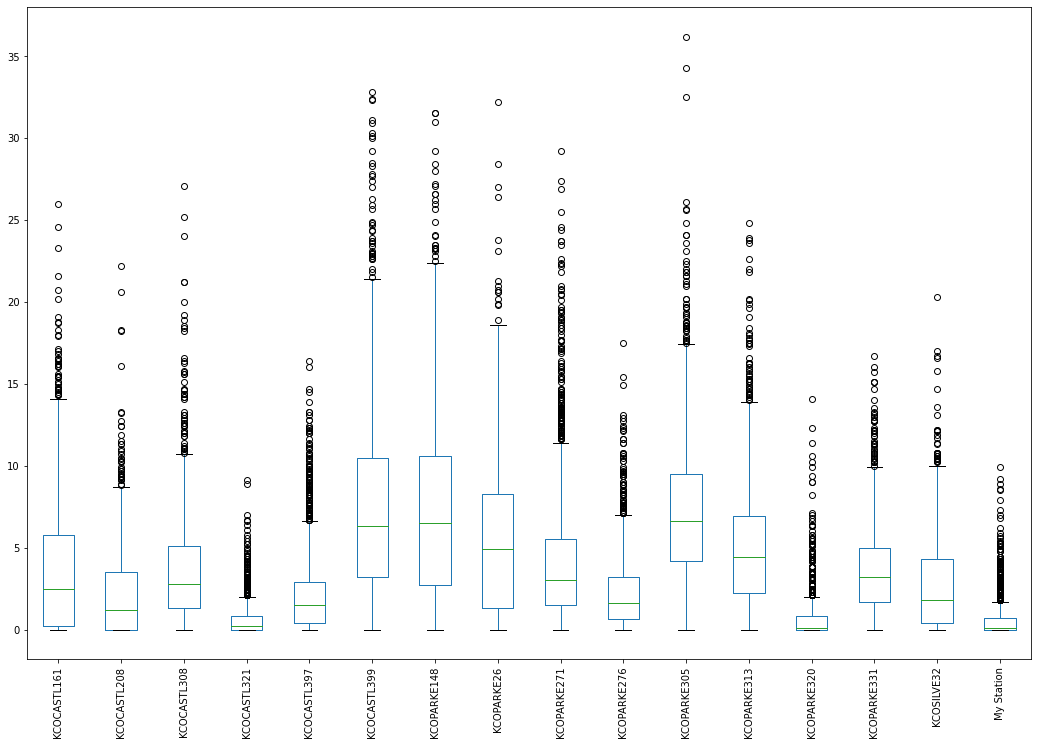

In [ ]:
# taking a look at the distribution of windspeedAvg and num_stations other stations most closely correlated to it
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations)
#need to flatten and stack all the windspeedAvg values
df_reshaped.rename(columns={my_station:'My Station'}, inplace=True)
df_reshaped.plot(kind='box', figsize=(18,12),rot=90)

In [ ]:
df_reshaped.describe()

stationID,KCOCASTL161,KCOCASTL208,KCOCASTL308,KCOCASTL321,KCOCASTL397,KCOCASTL399,KCOPARKE148,KCOPARKE26,KCOPARKE271,KCOPARKE276,KCOPARKE305,KCOPARKE313,KCOPARKE320,KCOPARKE331,KCOSILVE32,My Station
count,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000
mean,3.672360,2.191265,3.638462,0.624609,2.225359,7.449870,7.186343,5.480965,4.419426,2.329791,7.314472,5.115352,0.684583,3.620860,2.696545,0.623533
std,4.091044,2.684869,3.297548,1.020202,2.544472,5.620474,5.573828,4.655793,4.480962,2.372358,4.444967,3.952564,1.341528,2.684941,2.784564,1.147833
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.000000,1.300000,0.000000,0.400000,3.200000,2.700000,1.300000,1.500000,0.625000,4.200000,2.200000,0.000000,1.700000,0.400000,0.000000
50%,2.450000,1.200000,2.800000,0.200000,1.500000,6.300000,6.500000,4.900000,3.000000,1.600000,6.600000,4.400000,0.100000,3.200000,1.800000,0.100000
75%,5.800000,3.500000,5.100000,0.800000,2.900000,10.500000,10.600000,8.300000,5.500000,3.200000,9.500000,6.900000,0.800000,5.000000,4.300000,0.700000
max,26.000000,22.200000,27.100000,9.100000,16.400000,32.800000,31.500000,32.200000,29.200000,17.500000,36.200000,24.800000,14.100000,16.700000,20.300000,9.900000


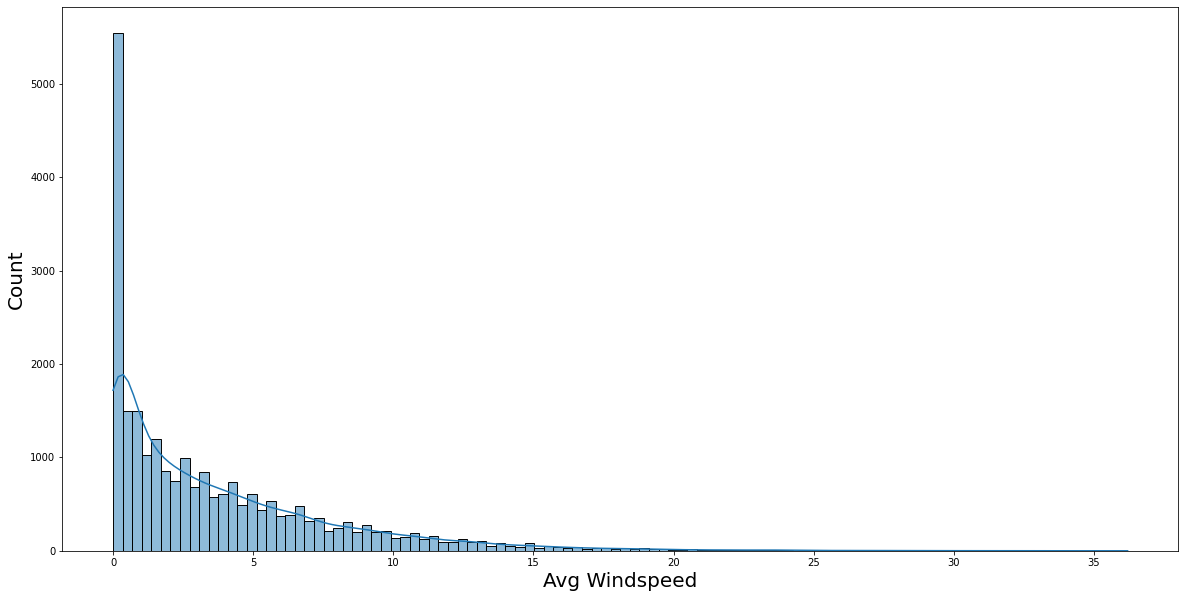

In [ ]:
to_plot = []
for col in df_reshaped.columns:
  to_plot += df_reshaped[col].to_list()

fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('Avg Windspeed', fontdict={'fontsize' : 20})
ax.set_ylabel('Count', fontdict={'fontsize' : 20})
sns.histplot(data=to_plot, kde=True,ax=ax)

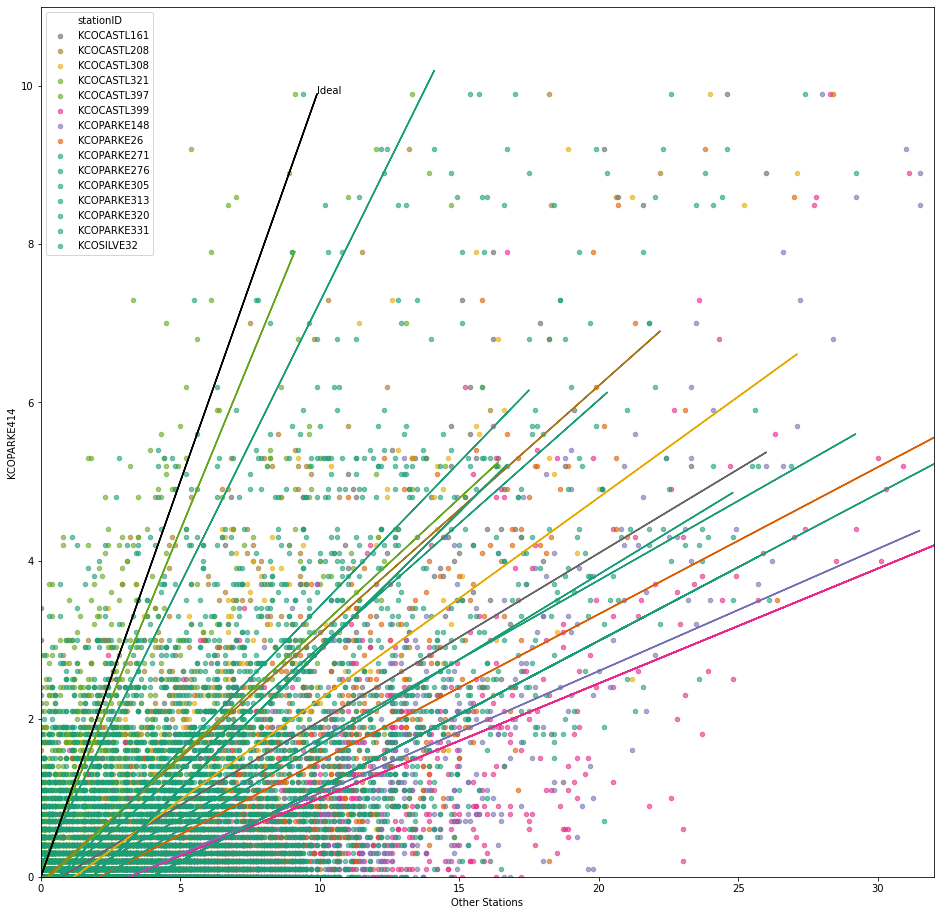

In [ ]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations)

columns_to_plot = list(df_reshaped.columns)
columns_to_plot.remove(my_station)
columns_to_plot.sort()
i = 0
colors = 'rgbym'
cmap = cm.get_cmap('Dark2')
cmap_counter = 0.9
cmap_tracker = {}

fig, ax = plt.subplots(figsize=(16,16))
# ax.set_aspect('equal')
# ax.set_xlim((0,30))
# ax.set_ylim((0,30))
# ax.set_xlabel(fontdict={'fontsize' : 12})
# ax.set_ylabel(fontdict={'fontsize' : 12})
for col in columns_to_plot:
  df_reshaped.plot(ax=ax, kind='scatter',y=my_station,x=col,color=cmap(cmap_counter),label=col,alpha=0.6)
  m, b = np.polyfit(df_reshaped[col], df_reshaped[my_station], 1)
  # ax.plot(df_reshaped[my_station],m*df_reshaped[my_station]+b, color=colors[i])
  ax.plot(df_reshaped[col],m*df_reshaped[col]+b, color=cmap(cmap_counter)) 
  cmap_tracker[col] = cmap(cmap_counter)
  i += 1
  cmap_counter -= .1
ax.plot(df_reshaped[my_station],df_reshaped[my_station],c='k')
ax.text(df_reshaped[my_station].max()+.01, df_reshaped[my_station].max(), 'Ideal')
ax.set_xlabel('Other Stations')
plt.xlim(0,32)
plt.ylim(0,11)
plt.show()

Trying LinearRegression with the num_stations above and include a StandardScaler

In [ ]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
model = LinearRegression()
model.fit(X_train_scaled,y_train)

scores = cross_val_score(model,scaler.transform(X_test),y_test,)
print('scores: {}\nAverage Score: {:.2f} Std: {:.2f}'.format(scores,np.mean(scores),np.std(scores) ))
best_model_tracker['LinearRegression with StandardScaler']= {'num_stations':num_stations,'best_params': None, 'best_avg':np.mean(scores)}

scores: [0.77880752 0.77438985 0.86226996 0.60155396 0.67429831]
Average Score: 0.74 Std: 0.09


### Lasso with a simple GridSearchCV to try different alphas to see if we can tune it and get better accuracy.

In [ ]:
ALPHAS=arange(0.01, 1.00, 0.01)

df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

pipe = Pipeline([
    ('regressor', Lasso())
])

param_grid = [
    {
        'regressor__alpha': ALPHAS
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)


GridSearchCV(cv=10, estimator=Pipeline(steps=[('regressor', Lasso())]),
             n_jobs=1,
             param_grid=[{'regressor__alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])}])

In [ ]:
# print("Accuracy: ", accuracy_score(y_test, y_pred))
# print('f1 score: ',f1_score(y_test,y_pred), 'with grid parameters:')
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['Lasso']= {'num_stations':num_stations,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__alpha': 0.01}
scores: [0.72943547 0.7849573  0.69635791 0.77600407 0.85687733]
Average Score: 0.77


### That doesn't some as too much of a surprise. The data wasn't sparse enough to really make the most use out of Lasso. Also, the fact that the best fit results for the grid search turned out to have an alpha of 0.01 means that we should go with a regular LinearRegression instead of Lasso since when alpha == 0 Lasso is just OLS.

### Ridge Regression

In [ ]:

ALPHAS=arange(.01,0.1,0.01)
NORMALIZE = [False,True]

df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull) #using the best # stations that we found for LinearRegression
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

pipe = Pipeline([
    ('regressor', Ridge())
])

param_grid = [
    {
        'regressor__alpha': ALPHAS,
        'regressor__normalize': NORMALIZE
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)


GridSearchCV(cv=10, estimator=Pipeline(steps=[('regressor', Ridge())]),
             n_jobs=1,
             param_grid=[{'regressor__alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                          'regressor__normalize': [False, True]}])

In [ ]:
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['Ridge']= {'num_stations':num_stations,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__alpha': 0.01, 'regressor__normalize': True}
scores: [0.94527391 0.36645577 0.82771581 0.90681225 0.78215216]
Average Score: 0.77


GridSearch with RandomForestRegressor

In [ ]:
N_FEATURES_OPTIONS = ["auto","sqrt","log2"]
ESTIMATOR_OPTIONS = [10, 15, 20, 25, 50]
MAX_DEPTH_OPTIONS = [75, 85, 90, 95, 100]

df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull)
X = np.array(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]).flatten() #target

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.1)

pipe = Pipeline([
    # ('reduce_dim', SelectKBest()),
    ('classify', RandomForestRegressor())
])

param_grid = [
    {
        'classify__max_features': N_FEATURES_OPTIONS,
        'classify__n_estimators': ESTIMATOR_OPTIONS,
        'classify__max_depth' : MAX_DEPTH_OPTIONS
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classify', RandomForestRegressor())]),
             n_jobs=1,
             param_grid=[{'classify__max_depth': [75, 85, 90, 95, 100],
                          'classify__max_features': ['auto', 'sqrt', 'log2'],
                          'classify__n_estimators': [10, 15, 20, 25, 50]}])

In [ ]:
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['RandomForestRegressor']= {'num_stations':num_stations,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'classify__max_depth': 100, 'classify__max_features': 'auto', 'classify__n_estimators': 50}
scores: [0.32428173 0.78723204 0.66035454 0.64241096 0.50037386]
Average Score: 0.58


Elastic Net - possibly of value as it is effective when we have multiple values correlated to one another. In theory, the windspeedAvg of stations highly correlated with mine should be highly correlated to one another.

In [ ]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull) #using the best # stations that we found for LinearRegression
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

# alpha=1.0, l1_ratio=0.5, fit_intercept=True, normalize=False

ALPHAS = arange(.01,0.1,0.01)
NORMALIZE = [False,True]
L1S = arange(.1,1.1,.1)
MAX_ITER = [1500, 2000, 2500]

pipe = Pipeline([
    ('regressor', ElasticNet())
])

param_grid = [
    {
        'regressor__alpha': ALPHAS,
        'regressor__l1_ratio': L1S,
        'regressor__normalize': NORMALIZE,
        'regressor__max_iter': MAX_ITER
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('regressor', ElasticNet())]),
             n_jobs=1,
             param_grid=[{'regressor__alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                          'regressor__l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                          'regressor__max_iter': [1500, 2000, 2500],
                          'regressor__normalize': [False, True]}])

In [ ]:
scores = cross_val_score(grid,X_test,y_test)
print(grid.best_params_)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['ElasticNet']= {'num_stations':num_stations,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__alpha': 0.01, 'regressor__l1_ratio': 1.0, 'regressor__max_iter': 2000, 'regressor__normalize': False}
scores: [0.8581197  0.78912907 0.88123586 0.83365255 0.80514106]
Average Score: 0.83


Bayesian Ridge Regression

In [ ]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull) #using the best # stations that we found for LinearRegression
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]).flatten() #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

# alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, normalize=False

ALPHA_1 = arange(.01,0.1,0.01)
ALPHA_2 = arange(.01,0.2,0.01)
LAMBDA_1 = arange(.01,0.1,0.01)
LAMBDA_2 = arange(.01,0.1,0.01)
NORMALIZE = [False,True]
# L1S = arange(.1,1.1,.1)

pipe = Pipeline([
    ('regressor', BayesianRidge())
])

param_grid = [
    {
        'regressor__normalize': NORMALIZE,
        'regressor__alpha_1': ALPHA_1,
        'regressor__alpha_2': ALPHA_2,
        # 'regressor__lambda_1': LAMBDA_1,
        # 'regressor__lambda_2': LAMBDA_2

    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('regressor', BayesianRidge())]),
             n_jobs=1,
             param_grid=[{'regressor__alpha_1': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                          'regressor__alpha_2': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
                          'regressor__normalize': [False, True]}])

In [ ]:
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['BayesianRidge']= {'num_stations':num_stations,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__alpha_1': 0.09, 'regressor__alpha_2': 0.01, 'regressor__normalize': True}
scores: [0.38853634 0.51782803 0.9392461  0.82823193 0.85641166]
Average Score: 0.71


Huber Regressor

In [ ]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull) #using the best # stations that we found for LinearRegression
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]).flatten() #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

# alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, normalize=False

EPSILON = arange(2,5,.1)
#increase max_iter
MAX_ITER = arange(101,301,50)

pipe = Pipeline([
    ('regressor', HuberRegressor())
])

param_grid = [
    {
        'regressor__epsilon': EPSILON,
        'regressor__max_iter': MAX_ITER

    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('regressor', HuberRegressor())]),
             n_jobs=1,
             param_grid=[{'regressor__epsilon': array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
       3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5,
       4.6, 4.7, 4.8, 4.9]),
                          'regressor__max_iter': array([101, 151, 201, 251])}])

In [ ]:
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
sleep(2)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['HuberRegressor']= {'num_stations':num_stations,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__epsilon': 2.1, 'regressor__max_iter': 151}
scores: [0.7581525  0.83077205 0.66006469 0.75687756 0.7010364 ]
Average Score: 0.74


Huber Regressor with StandardScaler

In [ ]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull) #using the best # stations that we found for LinearRegression
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]).flatten() #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

# alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, normalize=False

EPSILON = arange(2,5,.1)
#increase max_iter
MAX_ITER = arange(101,301,50)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', HuberRegressor())
])

param_grid = [
    {
        'regressor__epsilon': EPSILON,
        'regressor__max_iter': MAX_ITER

    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', HuberRegressor())]),
             n_jobs=1,
             param_grid=[{'regressor__epsilon': array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
       3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5,
       4.6, 4.7, 4.8, 4.9]),
                          'regressor__max_iter': array([101, 151, 201, 251])}])

In [ ]:
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
sleep(2)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['HuberRegressor with StandardScaler']= {'num_stations':num_stations,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__epsilon': 2.3000000000000003, 'regressor__max_iter': 201}
scores: [0.87862571 0.83132127 0.79167523 0.71745295 0.79759318]
Average Score: 0.80


Poisson Regression

In [ ]:

ALPHAS=arange(.2,2,0.2)

df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull) #using the best # stations that we found for LinearRegression
# df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations) #using the best # stations that we found for LinearRegression
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]).flatten() #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

pipe = Pipeline([
    ('regressor', PoissonRegressor())
])

param_grid = [
    {
        'regressor__alpha': ALPHAS
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('regressor', PoissonRegressor())]),
             n_jobs=1,
             param_grid=[{'regressor__alpha': array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8])}])

In [ ]:
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['Poisson']= {'num_stations':num_stations,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__alpha': 1.8}
scores: [0.50875134 0.7002485  0.73736576 0.73606476 0.59219378]
Average Score: 0.65


Poisson with StandardScaler

In [ ]:

ALPHAS=arange(.2,2,0.2)

df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull) #using the best # stations that we found for LinearRegression
# df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations) #using the best # stations that we found for LinearRegression
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]).flatten() #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', PoissonRegressor())
])

param_grid = [
    {
        'regressor__alpha': ALPHAS
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', PoissonRegressor())]),
             n_jobs=1,
             param_grid=[{'regressor__alpha': array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8])}])

In [ ]:
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['Poisson with StandardScaler']= {'num_stations':num_stations,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__alpha': 0.2}
scores: [ 0.64859821  0.71481707 -0.70235512  0.7725366   0.75871578]
Average Score: 0.44


### Tweedie

In [ ]:
ALPHAS=arange(1,4,0.1)
POWERS = [1,1.5]

df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull) #using the best # stations that we found for LinearRegression
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]).flatten() #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

pipe = Pipeline([
    ('regressor', TweedieRegressor(link='log',power=1.5))
])

param_grid = [
    {
        'regressor__alpha': ALPHAS,
        'regressor__power': POWERS
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('regressor',
                                        TweedieRegressor(link='log',
                                                         power=1.5))]),
             n_jobs=1,
             param_grid=[{'regressor__alpha': array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9]),
                          'regressor__power': [1, 1.5]}])

In [ ]:
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['Tweedie']= {'num_stations':num_stations,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__alpha': 1.9000000000000008, 'regressor__power': 1}
scores: [ 0.42603826  0.78044993  0.53972459  0.67757709 -0.47353544]
Average Score: 0.39


### Building a dictionary of some models and doing KFold across them. This was fine if I don't need to tweak the hyperparameters and just need to evaluation some different models. From here will probably do GridSearch on a few of the mor promising models to try and optimize the parameters

In [ ]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target

model_dict = {#'svr_rbf': SVR(kernel='rbf', C=1e3, gamma=0.1), 
              # 'svr_lin': SVR(kernel='linear', C=1e3), 
              'svr_poly': SVR(kernel='poly', C=1e3, degree=2)}
              
for k, model in model_dict.items() :
  # model = svr_poly
  scores = []
  kfold = KFold(n_splits=3, shuffle=True, random_state=42)

  for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train,:][my_station].ravel())
    score = model.score(X.iloc[test,:], y.iloc[test,:])
    scores.append(score)
  print(k)
  print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
  best_model_tracker['SVR poly kernel degree 2']= {'num_stations':num_stations,'best_params': '', 'best_avg':np.mean(scores)}

svr_poly
scores: [0.7307683824920594, 0.7720577358457706, 0.7978829797759759]
Average Score: 0.77


### Getting rid of some outliers with IsolationForest to see if that improves performance

In [ ]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull)
X = np.array(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]) #target
iso_forest = IsolationForest(n_estimators=200,verbose=True,random_state=42,bootstrap=True).fit(X,y)
iso_outliers = iso_forest.predict(X) ==-1
# np.sum(iso_outliers)
X_iso = X[~iso_outliers]
y_iso = y[~iso_outliers]
print('dropped {} ({:.2f}%) rows'.format((X.shape[0] - X_iso.shape[0]),100*(1-(X_iso.shape[0]/X.shape[0]))))

X_train, X_test, y_train, y_test = train_test_split(X_iso,y_iso,test_size=0.3)

model = LinearRegression()
model.fit(X_train,y_train)

scores = cross_val_score(model,X_test,y_test)
print('Linear Regression scores: {}\nAverage Score: {:.2f} Std: {:.2f}'.format(scores,np.mean(scores),np.std(scores) ))
best_model_tracker['Linear Regression iso outliers removed']= {'num_stations':num_stations,'best_params': '', 'best_avg':np.mean(scores)}

model = Ridge(alpha=0.02, normalize=True)
model.fit(X_train,y_train)

scores = cross_val_score(model,X_test,y_test)
print('Ridge scores: {}\nAverage Score: {:.2f} Std: {:.2f}'.format(scores,np.mean(scores),np.std(scores) ))
best_model_tracker['Ridge iso outliers removed']= {'num_stations':num_stations,'best_params': {'regressor__alpha': 0.02, 'regressor__normalize': True}, 'best_avg':np.mean(scores)}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


dropped 159 (13.27%) rows
Linear Regression scores: [0.71843923 0.53660938 0.65338523 0.56244678 0.72020854]
Average Score: 0.64 Std: 0.08
Ridge scores: [0.66306076 0.50388644 0.65565193 0.55575709 0.72271558]
Average Score: 0.62 Std: 0.08


In [ ]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull)
X = df_reshaped.drop(columns=my_station)
y = df_reshaped[[my_station]] #target
iso_forest = IsolationForest(n_estimators=200,verbose=True,random_state=42,bootstrap=True).fit(X,y)
iso_outliers = iso_forest.predict(X) ==-1
# np.sum(iso_outliers)
X_iso = X[~iso_outliers]
y_iso = y[~iso_outliers]

starttime = datetime.datetime.now()

model_dict = {#'svr_rbf': SVR(kernel='rbf', C=1e3, gamma=0.1), 
              # 'svr_lin': SVR(kernel='linear', C=1e3), 
              'svr_poly': SVR(kernel='poly', C=1e3, degree=2)}
              
for k, model in model_dict.items() :
  # model = svr_poly
  scores = []
  kfold = KFold(n_splits=3, shuffle=True, random_state=42)

  for i, (train, test) in enumerate(kfold.split(X_iso, y_iso)):
    model.fit(X.iloc[train,:], y.iloc[train,:][my_station].ravel())
    score = model.score(X.iloc[test,:], y.iloc[test,:])
    scores.append(score)
  print(k)
  print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
  best_model_tracker['SVR poly kernel 2 iso outliers removed']= {'num_stations':num_stations,'best_params': '', 'best_avg':np.mean(scores)}

print("elapsed time: {}".format(datetime.datetime.now() - starttime))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


svr_poly
scores: [0.7284486504546668, 0.7365599045100641, 0.6276440724746214]
Average Score: 0.70
elapsed time: 0:00:34.558970


In [ ]:
ALPHAS=arange(0.01, 1.00, 0.01)

df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull)
X = df_reshaped.drop(columns=my_station)
y = df_reshaped[[my_station]] #target
iso_forest = IsolationForest(n_estimators=200,verbose=True,random_state=42,bootstrap=True).fit(X,y)
iso_outliers = iso_forest.predict(X) ==-1
# np.sum(iso_outliers)
X_iso = X[~iso_outliers]
y_iso = y[~iso_outliers]

X_train, X_test, y_train, y_test = train_test_split(X_iso,y_iso,test_size=0.15)

pipe = Pipeline([
    ('regressor', Lasso())
])

param_grid = [
    {
        'regressor__alpha': ALPHAS
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


GridSearchCV(cv=10, estimator=Pipeline(steps=[('regressor', Lasso())]),
             n_jobs=1,
             param_grid=[{'regressor__alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])}])

In [ ]:
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['Lasso iso outliers removed']= {'num_stations':num_stations,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__alpha': 0.01}
scores: [0.49381221 0.67776082 0.72005357 0.48469038 0.67696161]
Average Score: 0.61


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


dropped 212 (13.82%) rows


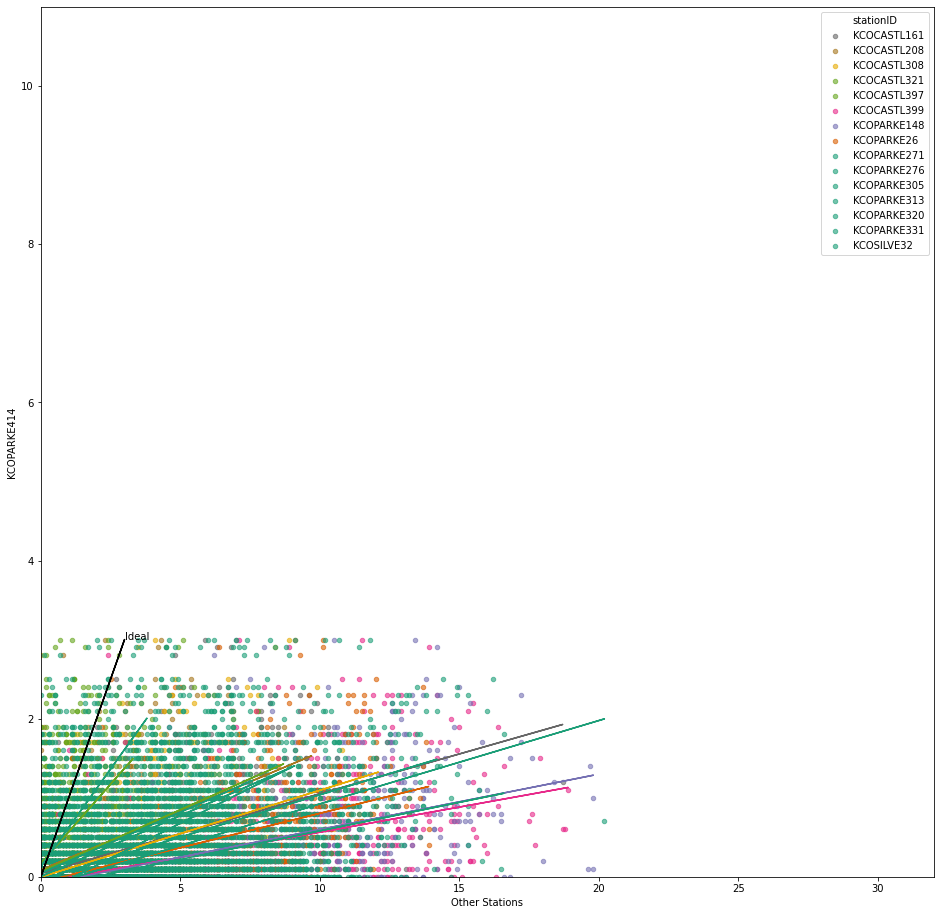

In [ ]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations)#,variable=columns_to_pull)
X = np.array(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]) #target
iso_forest = IsolationForest(n_estimators=200,verbose=True,random_state=42,bootstrap=True).fit(X,y)
iso_outliers = iso_forest.predict(X) ==-1
# np.sum(iso_outliers)
X_iso = X[~iso_outliers]
y_iso = y[~iso_outliers]
print('dropped {} ({:.2f}%) rows'.format((X.shape[0] - X_iso.shape[0]),100*(1-(X_iso.shape[0]/X.shape[0]))))

df_reshaped = df_reshaped[~iso_outliers]
columns_to_plot = list(set(df_reshaped.columns))
columns_to_plot.remove(my_station)
columns_to_plot.sort()
i = 0
colors = 'rgbym'
cmap = cm.get_cmap('Dark2')
cmap_counter = 0.9

fig, ax = plt.subplots(figsize=(16,16))
# ax.set_aspect('equal')
# ax.set_xlim((0,30))
# ax.set_ylim((0,30))
for col in columns_to_plot:
  df_reshaped.plot(ax=ax, kind='scatter',y=my_station,x=col,color=cmap_tracker.get(col,cmap(cmap_counter)),label=col,alpha=0.6)
  m, b = np.polyfit(df_reshaped[col], df_reshaped[my_station], 1)
  # ax.plot(df_reshaped[my_station],m*df_reshaped[my_station]+b, color=colors[i])
  ax.plot(df_reshaped[col],m*df_reshaped[col]+b, color=cmap_tracker.get(col,cmap(cmap_counter))) #color=colors[i]
  i += 1
  cmap_counter -= .1
ax.plot(df_reshaped[my_station],df_reshaped[my_station],c='k')
ax.text(df_reshaped[my_station].max()+.01, df_reshaped[my_station].max(), 'Ideal')
ax.set_xlabel('Other Stations')
plt.xlim(0,32)
plt.ylim(0,11)
plt.show()


Trying eliminating outliers using LocalOutlierFactor

In [ ]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations, variable=columns_to_pull)
X = np.array(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]) #target

lof_labels = LocalOutlierFactor(n_neighbors=60).fit_predict(X, y)
inliers = lof_labels == 1 # select inliers

X_lof = X[inliers]
y_lof = y[inliers]
print('dropped {} ({:.2f}%) rows'.format((X.shape[0] - X_lof.shape[0]),100*(1-(X_lof.shape[0]/X.shape[0]))))

X_train, X_test, y_train, y_test = train_test_split(X_lof,y_lof,test_size=0.3)

model = LinearRegression()
model.fit(X_train,y_train)

scores = cross_val_score(model,X_test,y_test)
print('Regression scores: {}\nAverage Score: {:.2f} Std: {:.2f}'.format(scores,np.mean(scores),np.std(scores) ))
best_model_tracker['Linear Regression localoutlierfactor removed']= {'num_stations':num_stations,'best_params': '', 'best_avg':np.mean(scores)}

model = Ridge(alpha=0.02, normalize=True)
model.fit(X_train,y_train)

scores = cross_val_score(model,X_test,y_test)
print('Ridge scores: {}\nAverage Score: {:.2f} Std: {:.2f}'.format(scores,np.mean(scores),np.std(scores) ))
best_model_tracker['Ridge localoutlierfactor removed']= {'num_stations':num_stations,'best_params': {'regressor__alpha': 0.02, 'regressor__normalize': True}, 'best_avg':np.mean(scores)}


dropped 31 (2.59%) rows
Regression scores: [0.71590854 0.65098489 0.61563163 0.84569374 0.57626175]
Average Score: 0.68 Std: 0.09
Ridge scores: [0.77515894 0.70452536 0.6541145  0.89617434 0.66547988]
Average Score: 0.74 Std: 0.09


In [ ]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target

X_lof = X[inliers]
y_lof = y[inliers]

starttime = datetime.datetime.now()

model_dict = {#'svr_rbf': SVR(kernel='rbf', C=1e3, gamma=0.1), 
              # 'svr_lin': SVR(kernel='linear', C=1e3), 
              'svr_poly': SVR(kernel='poly', C=1e3, degree=2)}
              
for k, model in model_dict.items() :
  # model = svr_poly
  scores = []
  kfold = KFold(n_splits=3, shuffle=True, random_state=42)

  for i, (train, test) in enumerate(kfold.split(X_lof, y_lof)):
    model.fit(X.iloc[train,:], y.iloc[train,:][my_station].ravel())
    score = model.score(X.iloc[test,:], y.iloc[test,:])
    scores.append(score)
  print(k)
  print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
  best_model_tracker['SVR poly kernel 2 localoutlierfactor removed']= {'num_stations':num_stations,'best_params': '', 'best_avg':np.mean(scores)}

print("elapsed time: {}".format(datetime.datetime.now() - starttime))

svr_poly
scores: [0.7109529773258575, 0.7447586734673789, 0.7829500751905394]
Average Score: 0.75
elapsed time: 0:00:50.963826


In [ ]:
ALPHAS=arange(0.01, 1.00, 0.01)

# df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations,variable=columns_to_pull)
# X = pd.DataFrame(df_reshaped.drop(columns=my_station))
# y = pd.DataFrame(df_reshaped[[my_station]]) #target

# X_lof = X[inliers]
# y_lof = y[inliers]

X_train, X_test, y_train, y_test = train_test_split(X_lof,y_lof,test_size=0.15)

pipe = Pipeline([
    ('regressor', Lasso())
])

param_grid = [
    {
        'regressor__alpha': ALPHAS
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('regressor', Lasso())]),
             n_jobs=1,
             param_grid=[{'regressor__alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])}])

In [ ]:
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['Lasso localoutlierfactor removed']= {'num_stations':num_stations,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__alpha': 0.02}
scores: [0.76284713 0.66552487 0.78266026 0.63775954 0.68060871]
Average Score: 0.71


In [ ]:
ALPHAS=arange(.2,2,0.2)
y_lof_array = np.array(y_lof).flatten()
X_train, X_test, y_train, y_test = train_test_split(X_lof,y_lof_array,test_size=0.15)

pipe = Pipeline([
    ('regressor', PoissonRegressor())
])

param_grid = [
    {
        'regressor__alpha': ALPHAS
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('regressor', PoissonRegressor())]),
             n_jobs=1,
             param_grid=[{'regressor__alpha': array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8])}])

In [ ]:
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['Poisson localoutlierfactor removed']= {'num_stations':num_stations,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__alpha': 1.8}
scores: [0.48332156 0.67707204 0.55055452 0.63059833 0.0421194 ]
Average Score: 0.48


dropped 367 (23.92%) rows


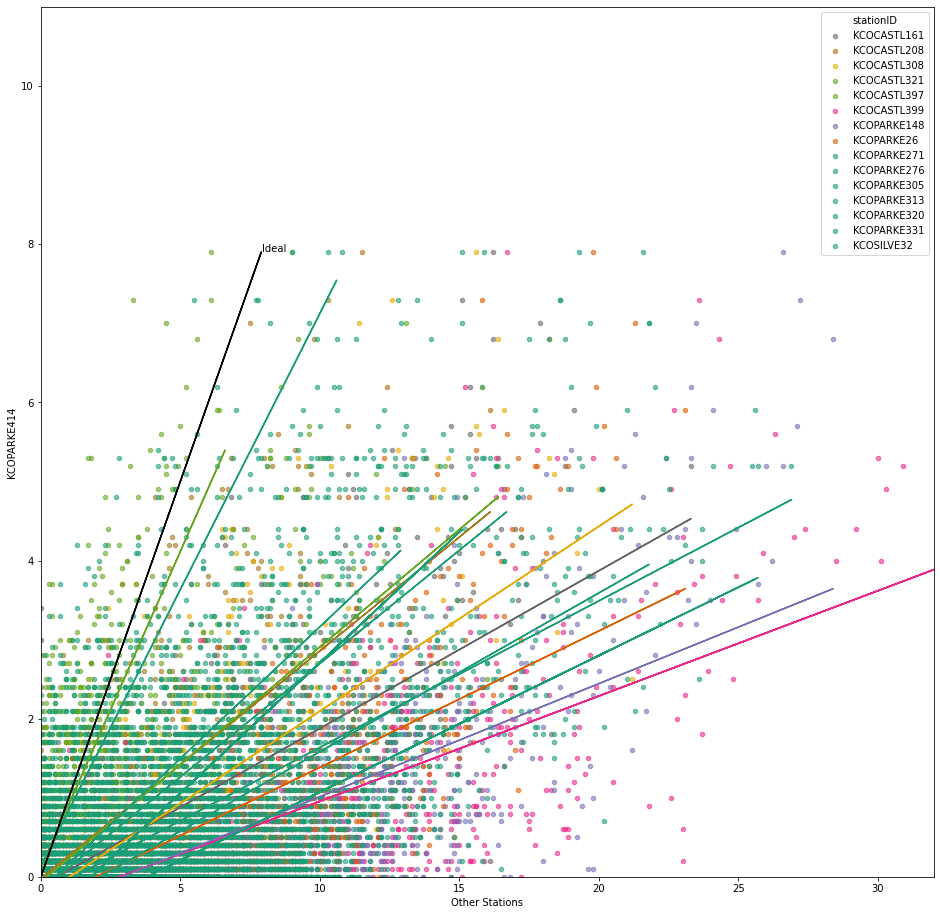

In [ ]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=num_stations)#,variable=columns_to_pull)
X = np.array(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]) #target

lof_labels = LocalOutlierFactor(n_neighbors=60).fit_predict(X, y)
inliers = lof_labels == 1 # select inliers

# X_lof = X[inliers]
# y_lof = y[inliers]
print('dropped {} ({:.2f}%) rows'.format((X.shape[0] - X_lof.shape[0]),100*(1-(X_lof.shape[0]/X.shape[0]))))

df_reshaped = df_reshaped[inliers]
columns_to_plot = list(set(df_reshaped.columns))
columns_to_plot.remove(my_station)
columns_to_plot.sort()
i = 0
colors = 'rgbym'
cmap = cm.get_cmap('Dark2')
cmap_counter = 0.9

fig, ax = plt.subplots(figsize=(16,16))
# ax.set_aspect('equal')
# ax.set_xlim((0,30))
# ax.set_ylim((0,30))
for col in columns_to_plot:
  df_reshaped.plot(ax=ax, kind='scatter',y=my_station,x=col,color=cmap_tracker.get(col,cmap(cmap_counter)),label=col,alpha=0.6)
  m, b = np.polyfit(df_reshaped[col], df_reshaped[my_station], 1)
  # ax.plot(df_reshaped[my_station],m*df_reshaped[my_station]+b, color=colors[i])
  ax.plot(df_reshaped[col],m*df_reshaped[col]+b, color=cmap_tracker.get(col,cmap(cmap_counter))) #color=colors[i]
  i += 1
  cmap_counter -= .1
ax.plot(df_reshaped[my_station],df_reshaped[my_station],c='k')
ax.text(df_reshaped[my_station].max()+.01, df_reshaped[my_station].max(), 'Ideal')
ax.set_xlabel('Other Stations')
plt.xlim(0,32)
plt.ylim(0,11)
plt.show()


## Evaluate the contents of the model tracker to see what model did the best

In [ ]:
best_model_tracker

{'BayesianRidge': {'best_avg': 0.7060508127249727,
  'best_params': {'regressor__alpha_1': 0.09,
   'regressor__alpha_2': 0.01,
   'regressor__normalize': True},
  'num_stations': 15},
 'ElasticNet': {'best_avg': 0.8334556474379589,
  'best_params': {'regressor__alpha': 0.01,
   'regressor__l1_ratio': 1.0,
   'regressor__max_iter': 2000,
   'regressor__normalize': False},
  'num_stations': 15},
 'HuberRegressor': {'best_avg': 0.7413806418826937,
  'best_params': {'regressor__epsilon': 2.1, 'regressor__max_iter': 151},
  'num_stations': 15},
 'HuberRegressor with StandardScaler': {'best_avg': 0.8033336676385835,
  'best_params': {'regressor__epsilon': 2.3000000000000003,
   'regressor__max_iter': 201},
  'num_stations': 15},
 'Lasso': {'best_avg': 0.7687264155558523,
  'best_params': {'regressor__alpha': 0.01},
  'num_stations': 15},
 'Lasso iso outliers removed': {'best_avg': 0.6106557193204646,
  'best_params': {'regressor__alpha': 0.01},
  'num_stations': 15},
 'Lasso localoutlierfac

In [ ]:
pd.set_option("display.max_colwidth",100)

In [ ]:
pd.DataFrame(best_model_tracker).T.sort_values("best_avg",ascending=False).drop(columns='num_stations')

,best_params,best_avg
LinearRegression,NaN,0.873127
ElasticNet,"{'regressor__alpha': 0.01, 'regressor__l1_ratio': 1.0, 'regressor__max_iter': 2000, 'regressor__...",0.833456
HuberRegressor with StandardScaler,"{'regressor__epsilon': 2.3000000000000003, 'regressor__max_iter': 201}",0.803334
Lasso,{'regressor__alpha': 0.01},0.768726
SVR poly kernel degree 2,,0.766903
Ridge,"{'regressor__alpha': 0.01, 'regressor__normalize': True}",0.765682
SVR poly kernel 2 localoutlierfactor removed,,0.746221
HuberRegressor,"{'regressor__epsilon': 2.1, 'regressor__max_iter': 151}",0.741381
Ridge localoutlierfactor removed,"{'regressor__alpha': 0.02, 'regressor__normalize': True}",0.739091
LinearRegression with StandardScaler,NaN,0.738264
